### TODO
* Explain: Approximations
* Explain: Linear approx.
* Explain: Q-learning extension
* Explain: SARSA extension
* Explain: Mountain Car env
* code: Run and compare (on mountain car)


### DONE


### NOTES

# Linear Approximate Methods for Reinforcement Learning

We want to be able to deal with arbitrarily big environments. For many realistic environments, the state space is simply too complex (i.e. too big) to realistically allow us to find an optimal policy, even under the assumption of infinite time and data. We then will try to *generalize* our policy from past experience. The type of generalization we require is often called **function approximation**. This notebook gives a brief overview on approximate methods for Reinforcement Learning, showing then extension of tabular methods liek SARSA to this new framework.

## (State-Action / State Value) Approximation

In practice, the way to apply function approximation to Reinforcement Learning is by *approximating the state value* $v_{\pi}$ from the *experience* generated using a known policy $\pi$.<br>
The key difference from tabular methods is that the value function is now represented as a *functional form parametrized by a weight vector* $\textbf{w}\in \mathbb{R}^d$, so that we will write the approximate of the state value for state $s$ as $\hat{v}(s, \textbf{w}) \approx v_{\pi}(s)$.<br>**TODO: are dimensionality and notations aligned with the tabular methods?**

**TODO: something relevant from section 9.1?**

It is important to note that we will have necessarily less weights than number of states, which implies that with function approximation updates on states are no longer *decoupled*. By that we mean that now an update on a state *influences many others*, and thus it is not possible to estimate correctly all the state values simultaneously. <br>
This is important to notice when we talk about the *error on a state $s$*: this error will be understood by the **squared difference between the approximate value** $\hat{v}(s,\textbf{w})$ **and the true value** $v_\pi (s)$, weighted by a specified **state distribution** $\mu(s)$:

$$ \overline{VE} = \sum_{s \in \mathcal{S}} \mu(s) \left[ v_\pi - \hat{v}(s,\textbf{w}) \right]^2 .$$

we will call this quantity the *Mean Squared Value Error*. Commonly, we will chose $\mu(s)$ to be the fraction of time spent on $s$ by the agent. We will call this distribution the *on-policy distribution*. <br>
Having specified this error function, the ideal goal will then be to find an optimal weight vector $\textbf{w}^*$ for which $\overline{VE}(\textbf{w}^*) \leq \overline{VE}(\textbf{w})$ for all possible $\textbf{w}$. In general this is not realistically achievable, so the goal of function approximation is to converge to a **local optimum**, in which the aforementioned relation holds but only in a *neighborhood* of $\textbf{w}^*$. 



## Stochastic Gradient Descent

We want to minimize the $\overline{VE}$ error taking into consideration the observed experience. *Stochastic Gradient Descent* (SGD) methods will allow us to do so by adjusting the weight vector after each example is observed from experience, moving it in the direction which most reduces the error evaluated on the considered experience. This direction is given by the **gradient** of the error function. This results in the update

$$ \textbf{w}_{t+1} = \textbf{w}_{t} + \frac{1}{2} \alpha \nabla\overline{VE} =$$
$$= \textbf{w}_{t} + \frac{1}{2} \alpha \nabla\left[ v_\pi (S_t) -\hat{v}(S_t,\textbf{w}_{t}) \right]^2 =$$
$$= \textbf{w}_{t} + \alpha\left[ v_\pi (S_t) -\hat{v}(S_t,\textbf{w}_{t}) \right] \nabla\hat{v}(S_t,\textbf{w}_{t}).$$

**TODO: this notation differentiates between s and S_t. Did we talk about this? Do we need to adapt stuff? Ignore and refer to Sutton?**

Obviously we will not have the true value $v_\pi(S_t)$ available, so we need to replace the target of the update with some *approximation* of it. <br>
The choice of how we decide to approximate $v_\pi$ gives rise to two families of algorithms: *true gradient methods* and *semi-gradient methods*. If we call $U_t$ the chosen approximation, the SGD weight update becomes

$$\textbf{w}_{t+1} = \textbf{w}_{t} + \alpha\left[ U_t -\hat{v}(S_t,\textbf{w}_{t}) \right] \nabla\hat{v}(S_t,\textbf{w}_{t}).$$

We can now see that if we choose $U_t$ to be an *unbiased estimate* of $v_\pi$ (so that $\mathbb{E}\left[U_t | S_t=s \right] = v_\pi (S_t)$ for each $t$), then $\textbf{w}_{t+1}$ is guaranteed to converge to a local optimum. This is the case if we choose as a target the *Monte Carlo target*, $U_t = G_t$. <br>
If, instead, we want to use **bootsrapped targets**, such as the *n-step return*, we should take into account the impact that the current estimation of the weight parameter $\textbf{w}_{t}$ has on the targets, but instead we decide to *ignore it*. This is reflected by the absence of the derivative w.r.o. $\textbf{w}_{t}$ of the target $U_t$ in the expression of the gradient. These methods are known as **semi-gradient methods**. 


## Linear Approximation

One of the easiest but nevertheless important function approximator is the one which approximates $\hat{v}(\cdot, \textbf{w})$ with a **linear function** of the weight vector $\textbf{w}$. Corresponding to each state $s$, thereis a real-valued vector $\textbf{x}(s)$ (with the same number of components as $\textbf{w}$) which we will call **feature vector** represeting the state $s$. Linear methods approximate the state-value function as the inner product between $\textbf{x}(s)$ and $\textbf{w}$:

$$ \hat{v}(s,\textbf{w}) = \textbf{w} \cdot \textbf{x}(s) = \sum_{i=1}^{d} w_i \cdot x_i(s).$$

The gradient of the approximate function w.r.o. the parameter vector $\textbf{w}$ in this case is simply $\nabla\hat{v}(s,\textbf{w})=\textbf{x}(s)$, so that the SGD update becomes

$$\textbf{w}_{t+1} = \textbf{w}_{t} + \alpha\left[ U_t -\hat{v}(S_t,\textbf{w}_{t}) \right] \textbf{x} (S_t)$$ 

Linear methods are useful for studying the convergence properties of approximate methods. In particular it is important to notice how linear methods assure the existance of *only one optimum*, so that any method that is able to converge to a local optimum is guaranteed to converge to the global optimum.

# Algorithms for on-policy control with approximation

The results regarding approximate methods for state-value estimation presented above are easily extended to **controlling tasks**: all that is required is to replace in the formuale the state-value function $v_\pi (s)$ with the *action-value function* $q_\pi (s,a)$.<br>
We will now present the *n-step SARSA algorithm* (as alread presented in the tabular case) adapted to function approximation for solving episodic tasks. We will then briefly go over the effects of introducing *off-policy methods* to function approximations.

## Episodic semi-gradient SARSA

According to what we said above, it should appear clear that the only thing left to specify in our update is the *target* $U_t$. If we choose it to be the **n-step return** as specified by Sutton and Barto [1]:

$$ G_{t:t+n} = R_{t+1} + \gamma R_{t+2} + \dots + \gamma^{n-1}R_{t+n} + \gamma^n \hat{q}(S_{t+n}, A_{t+n}, \textbf{w}_{t+n-1})$$

then the $n$-step update equation becomes:


$$ \textbf{w}_{t+n} = \textbf{w}_{t+n-1} + \alpha \left[ G_{t:t+n} - \hat{q}(S_{t}, A_{t}, \textbf{w}_{t+n-1}) \right]\nabla \hat{q}(S_{t}, A_{t}, \textbf{w}_{t+n-1}) $$

We've chosen as function approximator a *linear model*.

## The Deadly Triad

Having in mind the tabular methods, one could ask how off-policy training could influence function approximation. It can be shown that if we try to do so, approximate methods start to suffer from severe *instability* issues. Many counterexamples have been devised to show this behaviour. 
More generally, we can identify three main components that, if all present at the same time, give rise to stability issues:

- **Function Approximation**: it offers a scalable way of *generalizing state spaces* that are much larger than the available memory and computational resources. Clearly, this cannot be given away;
- **Boostrapping**: even if not strictly necessary, it offers boosts in *computational and data efficiency* which are too "tempting" to be given away;
- **Off-policy learning**: it is *essential* for certain use cases and play an important role in the creation of "intelligent agents" (see [1] for further reading);

The combination of all of these three components makes up the so-called **deadly triad**. 

# Environment: OpenAI gym

We test the *n-step SARSA* with *linear function approximation* on one of the environments offered in the **openai gym** toolkit. <br>
We choose the **Mountain Car** environment as subject of our tests. In this environment we are faced with the task of driving a car on a one-dimensional track. The car is positioned between two "mountains", and the goal is placed upon the rightmost mountain. The car's engine is not strong enough to push it over the slope, so to reach the goal is necessary to build up momentup by oscillating back and forth between the two mountains.<br>

**TODO: add env picutre**

The agent receives a reward of -1 on all timesteps until the car moves over the goal, which terminates the episode. The episode also terminates after 200 timesteps. There are three possible actions: accelerate backwards, accelerate forwards and do nothing. The car moves according to a simplified physics model. Each state $s$ is a two-dimensional vector where the first coordinate represents the position of the car on the one-dimensional track, whilst the second coordinate represents the car's velocity. 


## Tile Coding

We specified both the target and the approximator used in our algorithm, but we still haven't said anything about the **features** that we want to use. We have decided to use **tile coding** to map the state space into features.

**TODO: add tile coding picture**

Let's consider a bidimensional state space. Tile coding divides the state space into $n$ *bins*, which are then used to build a $n \times $-dimensional binary feature matrix $\textbf{x}$. Each component of the feature matrix, $x_{i,j}$, will be either $1$ or $0$ depending on whether the state is contained in the $\{i,j\}$-th bin or not. One of said binning of the state space is called a **tiling**. <br>
If we limit ourselves to only one tiling, we are simply aggregating together states and encoding them in a binary vector. A more strong encoding can be achieved by considering *overlapping tilings*: these are build by considering multiple tilings, each and one of them obtained by adding an *offset* to the original tiling. Say that we decide to use $m$ tilings to encode our state space, we will end up with a $m \times (n \times n)$ binary matrix representing a state $s$. <br>
Tile coding allows us to have a sparse representation of a continuous state space, and results in a flexible and computationally flexible feature transformation.

In [1]:
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import gym

import utils
from tileEncoder import TileEncoder
from agents import ApproximateNStepSARSA

In [3]:
#TODO: unify this with utils.run_loop so it is accomodated in both

def run_loop(env, agent, title, max_e=None):
    t = 0; i = 0; e = 0
    s, r, d, _ = env.reset()
    a_ = agent.action(s)
    ep_lens = []; rewards = []
    r_sum = 0
    since_last_plot = 0

    while True:
        i += 1; t += 1; since_last_plot += 1
        a = a_
        s_, r, d, _ = env.step(a)
        a_ = agent.action(s_)

        agent.update(s=s, a=a, r=r, s_=s_, a_=a_, d=d)
        r_sum += r
        s = np.copy(s_)

        if (e + 1) % 100 == 0:
            env.render()
            
            

        if d:
           
            ep_lens.append(i)
            rewards.append(r_sum)
            r_sum = 0; e += 1; i = 0
            s, r, d, _ = env.reset()

        if max_e and e >= max_e:
            break

    return ep_lens, rewards

# Experiments

Below we train approximate n-step SARSA the Mountain Car environment.
In this notebook we will use an $\epsilon$-greedy policy, with $\epsilon=0.1$ held constant, unless noted otherwise.
We encode the state space using tile coding, using $m = 8$ tilings and $n = 8$ bins for each tiling. 

During training we monitor 
- The cost-to-go function, intended as $- \max_a \hat{q}(s,a,\textbf{w})$

In addition, we render a full episode until termination after every 100 episodes. 

In [4]:
## Run settings
num_runs = 1  # Number of runs to average rewards over
eps_per_run = 500  # Number of episodes (terminations) per run
n = 1  # n parameter in n-step Bootstrapping

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


KeyboardInterrupt: 

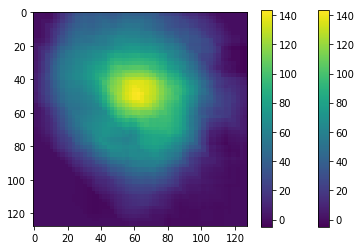

In [5]:
ApproxNSARSALearning_rewards = []
ApproxNSARSALearning_eplen = []
nbins = 8
ntiles = 8
env = TileEncoder(gym.make('MountainCar-v0'),nbins=nbins,ntiles=ntiles)
for i in range(num_runs):
    NSARSA_Learning = ApproximateNStepSARSA(env.obspace_shape(), env.nactions(), n=n)
    ep_lens, rewards = run_loop(env, NSARSA_Learning, 'NSARSALearning, n='+str(n), max_e=eps_per_run)
    ApproxNSARSALearning_rewards.append(rewards)
    ApproxNSARSALearning_eplen.append(ep_lens)

ApproxNSARSALearning_rewards  = np.array(ApproxNSARSALearning_rewards)
ApproxNSARSALearning_eplen = np.array(ApproxNSARSALearning_eplen)
env.close()

# Discussion

In [ ]:
#TODO: move costToGo plot into utils

plt.figure()
utils.reward_plotter(ApproxNSARSALearning_rewards, 'NSARSA', 'b')

axes = plt.gca()
axes.set_ylim([-200, 0])

plt.show()

res = 128
linspaces = []
for i in range(len(env.l_bound)): #do not consider number of tiles
    linspaces.append(np.linspace(env.l_bound[i],env.h_bound[i],num=res))  
mesh = np.meshgrid(linspaces[0],linspaces[1])

costToGo = np.zeros([res, res, env.nactions()])

for i in range(len(linspaces[0])):
    for j in range(len(linspaces[1])):
        s = env.encode([linspaces[0][i], linspaces[1][j]])
        qsa = NSARSA_Learning.linapprox(s)
        costToGo[i,j,:] = qsa
costToGo = -np.amax(costToGo,axis=2)

plt.imshow(costToGo)
plt.colorbar()

# Bibliographic Notes

[1] Richard S. Sutton and Andrew G. Barto. 1998. Introduction to Reinforcement Learning (1st ed.). MIT Press, Cambridge, MA, USA.